# Reproduce training from beginning

## setup path and get data

In [1]:
from pathlib import Path
import torch
from torch import nn, optim
from torch.nn import functional as F
import gzip
import pickle
# from fastai.datasets import download_data

import math
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
# MNIST_url = 'http://deeplearning.net/data/mnist/mnist.pkl'

In [5]:
home_path = Path('.').resolve()
data_path = home_path/'data'
file_name = data_path/'mnist.pkl.gz'

home_path, data_path, file_name

(PosixPath('/Users/xianli/Desktop/fast/Part2'),
 PosixPath('/Users/xianli/Desktop/fast/Part2/data'),
 PosixPath('/Users/xianli/Desktop/fast/Part2/data/mnist.pkl.gz'))

In [6]:
with gzip.open(file_name,'r') as f:
    ((x_train,y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    
x_train,y_train, x_valid, y_valid = map(torch.tensor, (x_train,y_train, x_valid, y_valid))

type(x_train), x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

(torch.Tensor,
 torch.Size([50000, 784]),
 torch.Size([50000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

# Create model

In [7]:
class Model(nn.Module):
    def __init__(self, fan_in, nh, fan_out):
        super().__init__()
        self.layers = [nn.Linear(fan_in, nh), nn.ReLU(), nn.Linear(nh, fan_out)] # initialization done inside layer definitions
    
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [8]:
fan_in = 28**2
nh = 50
fan_out = 10

model = Model(fan_in, nh, fan_out)

In [9]:
z = model(x_train)
z.shape

torch.Size([50000, 10])

In [10]:
z.max(-1,keepdim=True)[0].shape

torch.Size([50000, 1])

# CrossEntropyLoss
- logits z needs to be converted to probabilities --> softmax --> log-likelihood: logsoftmax
- calculate cross entropy

In [11]:
def softmax(x): return x.exp()/(x.exp().sum(-1, keepdim=True))

compute the log of the sum of exponentials in a more stable way, called the [LogSumExp trick](https://en.wikipedia.org/wiki/LogSumExp). The idea is to use the following formula:

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

where a is the maximum of the $x_{j}$.

In [12]:
def logsumexp(x): 
    a = x.max(-1,keepdim=True)[0]
    return a+(x-a).exp().sum(-1,keepdim=True).log()

In [13]:
# verify if our logsumexp is correct
torch.allclose(logsumexp(z),z.logsumexp(-1,keepdim=True),rtol=1e-3)

True

In [14]:
def log_softmax(x):  
    return x-logsumexp(x)

In [15]:
softmax(z).shape, logsumexp(z).shape, log_softmax(z).shape

(torch.Size([50000, 10]), torch.Size([50000, 1]), torch.Size([50000, 10]))

In [16]:
# negative log likelihood loss == cross entropy loss
# there is a pytorch function F.nll_loss for this
def nll(log_p_pred, y):
    # p_pred is essentially one-hot encoded. In MNIST case, y values directly correspond to the indices
    return -log_p_pred[range(y.shape[0]),y].mean(0)

In [17]:
p_pred = log_softmax(z)
our_loss = nll(p_pred, y_train)
our_loss

tensor(2.2999, grad_fn=<NegBackward>)

- Pytorch cross entropy loss will automatically convert logits into probability and calculate negative log-likehood

In [18]:
# standard cross entropy loss from pytorch
standard_loss = F.cross_entropy(z, y_train)
standard_loss

tensor(2.3000, grad_fn=<NllLossBackward>)

In [19]:
torch.allclose(our_loss, standard_loss)

True

In [20]:
# refactor
def my_CrossEntropy_MNIST(pred, targ):
    log_z = z - z.logsumexp(-1, keepdim=True)
    return -log_z[range(targ.shape[0]),targ].mean(0)

In [21]:
torch.allclose(F.cross_entropy(z, y_train), my_CrossEntropy_MNIST(z, y_train))

True

# Basic version of training 

In [22]:
InteractiveShell.ast_node_interactivity = "last_expr"

In [23]:
loss_func = F.cross_entropy # note nn.CrossEntropyLoss() is a class but F.crossentropy() is a function

In [24]:
def accuracy(pred, targ):
    return (torch.argmax(pred, dim=1)==targ).float().mean()

In [25]:
bs = 64
lr = 0.1
epoch = 2
n = x_train.shape[0]

In [26]:
model = Model(fan_in, nh, fan_out)

for ep in range(epoch):
    print('Begin epoch #%d' %(ep+1))
    for i in range((n-1)//bs+1): # loop by mini-batch
        # get batch
        batch_start = i*bs
        batch_end = batch_start+bs
        x_batch = x_train[batch_start:batch_end]
        y_batch = y_train[batch_start:batch_end]
        
        # generate prediction
        pred = model(x_batch) 
        # get loss
        loss = loss_func(pred, y_batch)
        if i%50 == 0:
            print('Current training accuracy = %f' %accuracy(pred, y_batch))

        # backprop and sdg
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l,'weight'):
                    l.weight -= lr*l.weight.grad
                    l.bias -= lr*l.bias.grad
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()

Begin epoch #1
Current training accuracy = 0.109375
Current training accuracy = 0.750000
Current training accuracy = 0.890625
Current training accuracy = 0.921875
Current training accuracy = 0.875000
Current training accuracy = 0.828125
Current training accuracy = 0.875000
Current training accuracy = 0.906250
Current training accuracy = 0.921875
Current training accuracy = 0.953125
Current training accuracy = 0.875000
Current training accuracy = 0.906250
Current training accuracy = 0.906250
Current training accuracy = 0.906250
Current training accuracy = 0.890625
Current training accuracy = 0.953125
Begin epoch #2
Current training accuracy = 0.921875
Current training accuracy = 0.890625
Current training accuracy = 0.953125
Current training accuracy = 0.937500
Current training accuracy = 0.937500
Current training accuracy = 0.859375
Current training accuracy = 0.937500
Current training accuracy = 0.921875
Current training accuracy = 0.906250
Current training accuracy = 0.953125
Current 

# Simplifcation 1: build model.parameters() with `__setattr__`
- register the name of the attribute whenever one is created

In [27]:
class DummyModule():
    def __init__(self,dim_in,nh,dim_out):
        self._modules = {} # a dictionary to store the attribute names, __dict__ is the built-in one
        self.lin1 = nn.Linear(dim_in,nh)
        self.lin2 = nn.Linear(nh, dim_out)
    
    def __setattr__(self, name, val):
        if not name.startswith('_'): 
            self._modules[name] = val # record the attribute name
        super().__setattr__(name,val) # override the default setattr
    
    def __repr__(self):
        return f"{self._modules}"
    
    def parameters(self): # a generator
        for l in self._modules.values(): # iter through the dictionary, note values() should be a function 
            for p in l.parameters():
                yield p

In [28]:
dm = DummyModule(784,50,10)
dm

{'lin1': Linear(in_features=784, out_features=50, bias=True), 'lin2': Linear(in_features=50, out_features=10, bias=True)}

In [29]:
[p.shape for p in dm.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

In [30]:
class Model(nn.Module): # model.parameters() won't work if the layers are not attributes of the object
    def __init__(self, fan_in,nh,fan_out):
        super().__init__()
        self.lin1 = nn.Linear(fan_in,nh)
        self.lin2 = nn.Linear(nh,fan_out)
    
    def __call__(self, x):
        return self.lin2(F.relu(self.lin1(x)))

In [31]:
fan_in = 28**2
nh = 50
fan_out = 10
model = Model(fan_in, nh, fan_out)
print(model)
print([p.shape for p in model.parameters()])

def fit():
    for ep in range(epoch):
        print('Begin epoch #%d' %(ep+1))
        for i in range((n-1)//bs+1): # loop by mini-batch
            # get batch
            batch_start = i*bs
            batch_end = batch_start+bs
            x_batch = x_train[batch_start:batch_end]
            y_batch = y_train[batch_start:batch_end]

            # generate prediction
            pred = model(x_batch) 
            # get loss
            loss = loss_func(pred, y_batch)
            if i%50 == 0:
                print('Current training accuracy = %f' %accuracy(pred, y_batch))

            # backprop and sdg
            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= lr*p.grad
                model.zero_grad()

Model(
  (lin1): Linear(in_features=784, out_features=50, bias=True)
  (lin2): Linear(in_features=50, out_features=10, bias=True)
)
[torch.Size([50, 784]), torch.Size([50]), torch.Size([10, 50]), torch.Size([10])]


In [32]:
fit()

Begin epoch #1
Current training accuracy = 0.109375
Current training accuracy = 0.781250
Current training accuracy = 0.859375
Current training accuracy = 0.859375
Current training accuracy = 0.906250
Current training accuracy = 0.828125
Current training accuracy = 0.890625
Current training accuracy = 0.906250
Current training accuracy = 0.906250
Current training accuracy = 0.953125
Current training accuracy = 0.875000
Current training accuracy = 0.906250
Current training accuracy = 0.906250
Current training accuracy = 0.921875
Current training accuracy = 0.859375
Current training accuracy = 0.953125
Begin epoch #2
Current training accuracy = 0.921875
Current training accuracy = 0.890625
Current training accuracy = 0.921875
Current training accuracy = 0.937500
Current training accuracy = 0.953125
Current training accuracy = 0.843750
Current training accuracy = 0.937500
Current training accuracy = 0.921875
Current training accuracy = 0.937500
Current training accuracy = 0.953125
Current 

### Use `self.add_module` to register layers

In [33]:
layers = [nn.Linear(fan_in, nh), nn.ReLU(), nn.Linear(nh, fan_out)]

In [34]:
class Model2(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i, l in enumerate(layers):
            self.add_module(f'Layer_{i}', l)
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [35]:
model2 = Model2(layers)
model2

Model2(
  (Layer_0): Linear(in_features=784, out_features=50, bias=True)
  (Layer_1): ReLU()
  (Layer_2): Linear(in_features=50, out_features=10, bias=True)
)

### register automatically using `nn.ModuleList`

In [36]:
class Model3(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [37]:
model3 = Model3(layers)
model3

Model3(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

### Sequential

In [38]:
model = nn.Sequential(nn.Linear(fan_in,nh),nn.ReLU(),nn.Linear(nh,fan_out))
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

In [39]:
fit()

Begin epoch #1
Current training accuracy = 0.109375
Current training accuracy = 0.781250
Current training accuracy = 0.859375
Current training accuracy = 0.875000
Current training accuracy = 0.890625
Current training accuracy = 0.828125
Current training accuracy = 0.906250
Current training accuracy = 0.875000
Current training accuracy = 0.890625
Current training accuracy = 0.937500
Current training accuracy = 0.859375
Current training accuracy = 0.890625
Current training accuracy = 0.906250
Current training accuracy = 0.921875
Current training accuracy = 0.921875
Current training accuracy = 0.953125
Begin epoch #2
Current training accuracy = 0.921875
Current training accuracy = 0.890625
Current training accuracy = 0.921875
Current training accuracy = 0.921875
Current training accuracy = 0.921875
Current training accuracy = 0.875000
Current training accuracy = 0.937500
Current training accuracy = 0.921875
Current training accuracy = 0.906250
Current training accuracy = 0.953125
Current 

# Use Pytorch optim

In [40]:
lr = 0.01
model = nn.Sequential(nn.Linear(fan_in,nh),nn.ReLU(),nn.Linear(nh,fan_out))
optimizer = optim.SGD(model.parameters(), lr=lr)

In [41]:
def fit():
    for ep in range(epoch):
        print('Begin epoch #%d' %(ep+1))
        for i in range((n-1)//bs+1): # loop by mini-batch
            # get batch
            batch_start = i*bs
            batch_end = batch_start+bs
            x_batch = x_train[batch_start:batch_end]
            y_batch = y_train[batch_start:batch_end]

            # generate prediction
            pred = model(x_batch) 
            # get loss
            loss = loss_func(pred, y_batch)
            if i%50 == 0:
                print('Current training accuracy = %f' %accuracy(pred, y_batch))

            # backprop and sdg
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

In [42]:
fit()

Begin epoch #1
Current training accuracy = 0.015625
Current training accuracy = 0.203125
Current training accuracy = 0.390625
Current training accuracy = 0.546875
Current training accuracy = 0.640625
Current training accuracy = 0.640625
Current training accuracy = 0.781250
Current training accuracy = 0.796875
Current training accuracy = 0.750000
Current training accuracy = 0.828125
Current training accuracy = 0.828125
Current training accuracy = 0.875000
Current training accuracy = 0.859375
Current training accuracy = 0.890625
Current training accuracy = 0.781250
Current training accuracy = 0.906250
Begin epoch #2
Current training accuracy = 0.875000
Current training accuracy = 0.859375
Current training accuracy = 0.890625
Current training accuracy = 0.875000
Current training accuracy = 0.875000
Current training accuracy = 0.781250
Current training accuracy = 0.890625
Current training accuracy = 0.875000
Current training accuracy = 0.843750
Current training accuracy = 0.890625
Current 

# Dataset and Dataloader
- Dataset base class just allows basic operations like indexing and len
- Dataloader yields data in batches

In [43]:
class Dataset():
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __getitem__(self,i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.x.shape[0]

In [48]:
y_train.shape

torch.Size([50000])

In [44]:
ds_train = Dataset(x_train, y_train)
ds_valid = Dataset(x_valid,y_valid)

In [45]:
len(ds_train), len(ds_valid)

(50000, 10000)

In [50]:
x, y = ds_train[:5]
x.shape, y.shape

(torch.Size([5, 784]), torch.Size([5]))

In [51]:
class DataLoader():
    def __init__(self, ds, bs=64):
        self.ds = ds
        self.bs = bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs):
            yield self.ds[i:i+self.bs]

In [53]:
loader = DataLoader(ds_train, bs=10001)
for o in loader:
    xb, yb = o
    print(f'xb shape = {xb.shape}, yb shape = {yb.shape}')

xb shape = torch.Size([10001, 784]), yb shape = torch.Size([10001])
xb shape = torch.Size([10001, 784]), yb shape = torch.Size([10001])
xb shape = torch.Size([10001, 784]), yb shape = torch.Size([10001])
xb shape = torch.Size([10001, 784]), yb shape = torch.Size([10001])
xb shape = torch.Size([9996, 784]), yb shape = torch.Size([9996])


In [84]:
valid_loader = DataLoader(ds_valid, bs = 64)
val_gen = iter(valid_loader)

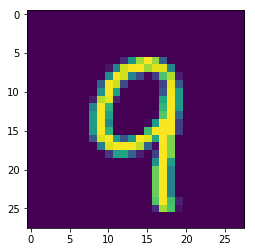

In [91]:
xv, yv = next(val_gen)
plt.imshow(xv[0].view(28,28))

### rewrite the training loop

In [60]:
fan_in, nh, fan_out = 784, 50, 10
lr = 0.05
def get_model():
    model = nn.Sequential(nn.Linear(fan_in,nh),nn.ReLU(),nn.Linear(nh,fan_out))
    opt = optim.SGD(model.parameters(), lr=lr)
    return model, opt

In [61]:
epochs = 2
bs = 64
ds_train = Dataset(x_train, y_train)
ds_loader = DataLoader(ds_train, bs)
model, opt = get_model()

def fit():
    for ep in range(epochs):
        i = 0
        print(f'begin epoch #{ep+1}')
        for xb, yb in ds_loader:
            pred = model(xb)
            loss = loss_func(pred, yb)
            if not i % 50:
                acc = accuracy(pred, yb)
                print(f'Training loss = {loss.item()}, accuracy = {acc}')
            loss.backward()
            opt.step()
            opt.zero_grad()
            i+=1

In [62]:
fit()

begin epoch #1
Training loss = 2.304140567779541, accuracy = 0.125
Training loss = 1.673831582069397, accuracy = 0.703125
Training loss = 0.934434711933136, accuracy = 0.8125
Training loss = 0.6859035491943359, accuracy = 0.84375
Training loss = 0.5768215656280518, accuracy = 0.859375
Training loss = 0.755027174949646, accuracy = 0.8125
Training loss = 0.48127150535583496, accuracy = 0.890625
Training loss = 0.3903617262840271, accuracy = 0.84375
Training loss = 0.3743698000907898, accuracy = 0.890625
Training loss = 0.31659597158432007, accuracy = 0.90625
Training loss = 0.39633673429489136, accuracy = 0.859375
Training loss = 0.4195123314857483, accuracy = 0.921875
Training loss = 0.262899786233902, accuracy = 0.9375
Training loss = 0.3345005214214325, accuracy = 0.890625
Training loss = 0.4275611639022827, accuracy = 0.890625
Training loss = 0.2290865033864975, accuracy = 0.96875
begin epoch #2
Training loss = 0.3891805410385132, accuracy = 0.921875
Training loss = 0.299789667129516

# Enrich dataloader: random sampler

In [99]:
class Sampler(): # only spit out indices, not real data, to save space
    def __init__(self, ds, bs=bs, shuffle=False):
        self.n = len(ds)
        self.bs = bs
        self.shuffle = shuffle
    def __iter__(self):
        if self.shuffle:
            idxs = torch.randperm(self.n)
        else:
            idxs = torch.arange(self.n)
        for i in range(0, self.n, self.bs):
            yield idxs[i:i+bs]

In [103]:
small_ds = Dataset(*ds_train[:5]) # * because dataset takes two parameters
bs = 3
sampler = Sampler(small_ds, bs, shuffle=True)
next(iter(sampler)),next(iter(sampler)),next(iter(sampler))

(tensor([3, 0, 2]), tensor([4, 3, 0]), tensor([1, 3, 4]))

In [109]:
# Unpack a list of tuples
tmp = [(1,2),(3,4),(5,6)]
a, b = zip(*tmp)
a, b

((1, 3, 5), (2, 4, 6))

In [110]:
def collate_fn(data_list):
    # data_list is a list of tuples of (x,y)
    xt,yt = zip(*data_list)
    return torch.stack(xt), torch.stack(yt)

In [116]:
# collate function test
data_list = [([1,2,3],2),([3,4,5],4),([4,5,6],6)]
data_list = [(torch.tensor(ele[0]),torch.tensor(ele[1])) for ele in data_list]
collate_fn(data_list)

(tensor([[1, 2, 3],
         [3, 4, 5],
         [4, 5, 6]]), tensor([2, 4, 6]))

In [117]:
class DataLoader():
    def __init__(self, ds, sampler, collate_fn = collate_fn):
        self.ds = ds
        self.sampler = sampler
        self.collate_fn = collate_fn
    
    def __iter__(self):
        for s in self.sampler: # yield indices
            yield self.collate_fn([self.ds[i] for i in s]) # our dataset class doesn't necessarily allow advanced indexing? 

In [125]:
bs = 5
ds_train = Dataset(x_train, y_train)
sampler = Sampler(ds_train, bs, shuffle=True)
loader = DataLoader(ds_train, sampler, collate_fn=collate_fn)
gen = iter(loader)
next(gen) # batch size of 3

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([9, 4, 1, 3, 4]))

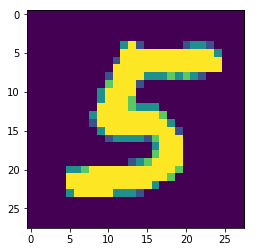

In [129]:
img = next(gen)[0][0]
plt.imshow(img.view(28,28))

### rewrite fit function

In [132]:
fan_in, nh, fan_out = 784, 50, 10
lr = 0.01
def get_model():
    model = nn.Sequential(nn.Linear(fan_in,nh),nn.ReLU(),nn.Linear(nh,fan_out))
    opt = optim.SGD(model.parameters(), lr=lr)
    return model, opt

In [133]:
epochs = 2
bs = 64
ds_train = Dataset(x_train, y_train)
sampler = Sampler(ds_train, bs, shuffle=True)
ds_loader = DataLoader(ds_train, sampler, collate_fn=collate_fn)
model, opt = get_model()

def fit():
    for ep in range(epochs):
        i = 0
        print(f'begin epoch #{ep+1}')
        for xb, yb in ds_loader:
            pred = model(xb)
            loss = loss_func(pred, yb)
            if not i % 50:
                acc = accuracy(pred, yb)
                print(f'Training loss = {loss.item()}, accuracy = {acc}')
            loss.backward()
            opt.step()
            opt.zero_grad()
            i+=1

In [134]:
fit()

begin epoch #1
Training loss = 2.318932056427002, accuracy = 0.109375
Training loss = 2.197685956954956, accuracy = 0.375
Training loss = 2.121443033218384, accuracy = 0.484375
Training loss = 1.9659712314605713, accuracy = 0.640625
Training loss = 1.7924023866653442, accuracy = 0.640625
Training loss = 1.62751305103302, accuracy = 0.71875
Training loss = 1.5172816514968872, accuracy = 0.75
Training loss = 1.3552361726760864, accuracy = 0.78125
Training loss = 1.236562967300415, accuracy = 0.71875
Training loss = 1.2065951824188232, accuracy = 0.75
Training loss = 1.048667073249817, accuracy = 0.828125
Training loss = 0.9769032001495361, accuracy = 0.828125
Training loss = 0.8507418632507324, accuracy = 0.8125
Training loss = 0.7453125715255737, accuracy = 0.84375
Training loss = 0.916109561920166, accuracy = 0.75
Training loss = 0.6023349761962891, accuracy = 0.890625
begin epoch #2
Training loss = 0.7895714044570923, accuracy = 0.796875
Training loss = 0.5712854862213135, accuracy = 

# Pytorch dataset and dataloader

In [135]:
from torch.utils.data import Dataset, DataLoader, SequentialSampler, RandomSampler

In [140]:
ds_train = Dataset(x_train, y_train) # our dataset class works for pytorch as well
ds_valid = Dataset(x_valid, y_valid) # or use pytorch dataset

In [141]:
dl_train = DataLoader(ds_train, bs, sampler = RandomSampler(ds_train), collate_fn=collate_fn)
dl_valid = DataLoader(ds_valid, bs, sampler = SequentialSampler(ds_valid), collate_fn=collate_fn)

In [144]:
# or even simpler
dl_train = DataLoader(ds_train, bs, shuffle=True)
dl_valid = DataLoader(ds_valid, bs, shuffle=False)

In [145]:
model, opt = get_model()

def fit():
    for ep in range(epochs):
        i = 0
        print(f'begin epoch #{ep+1}')
        for xb, yb in dl_train:
            pred = model(xb)
            loss = loss_func(pred, yb)
            if not i % 50:
                acc = accuracy(pred, yb)
                print(f'Training loss = {loss.item()}, accuracy = {acc}')
            loss.backward()
            opt.step()
            opt.zero_grad()
            i+=1

In [146]:
fit()

begin epoch #1
Training loss = 2.288123369216919, accuracy = 0.125
Training loss = 2.2213871479034424, accuracy = 0.296875
Training loss = 2.120112657546997, accuracy = 0.625
Training loss = 2.005922794342041, accuracy = 0.671875
Training loss = 1.8612971305847168, accuracy = 0.640625
Training loss = 1.7352294921875, accuracy = 0.734375
Training loss = 1.5491865873336792, accuracy = 0.828125
Training loss = 1.5020273923873901, accuracy = 0.765625
Training loss = 1.241751790046692, accuracy = 0.765625
Training loss = 1.057792067527771, accuracy = 0.84375
Training loss = 1.028617024421692, accuracy = 0.8125
Training loss = 0.8389776945114136, accuracy = 0.8125
Training loss = 0.9260385632514954, accuracy = 0.796875
Training loss = 0.736692488193512, accuracy = 0.921875
Training loss = 0.651896595954895, accuracy = 0.921875
Training loss = 0.8481499552726746, accuracy = 0.796875
begin epoch #2
Training loss = 0.7619929313659668, accuracy = 0.875
Training loss = 0.681962788105011, accuracy

# Final refactoring
- packing dataloaders
- packing model and optims
- packing fit function

In [166]:
fan_in, nh, fan_out = 784, 50, 10
lr = 0.05
def get_model():
    model = nn.Sequential(nn.Linear(fan_in,nh),nn.ReLU(),nn.Linear(nh,fan_out))
    opt = optim.SGD(model.parameters(), lr=lr)
    return model, opt

In [167]:
def get_dls(ds_train, ds_valid, bs=64, **kwargs):
    return DataLoader(ds_train, bs, shuffle=True, **kwargs), DataLoader(ds_valid, bs*2, shuffle=False, **kwargs)

In [168]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for ep in range(epochs):
        print(f'begin epoch #{ep+1}')
        i = 0
        # training mode
        model.train()
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            if not i % 200:
                acc = accuracy(pred, yb)
                print(f'Training loss = {loss.item()}, accuracy = {acc}')
            loss.backward()
            opt.step()
            opt.zero_grad()
            i+=1
            
        model.eval() # evaluation mode, no gradient calculated
        with torch.no_grad():
            tot_loss = 0.
            tot_acc = 0.
            for xb, yb in valid_dl:
                pred = model(xb)
                tot_loss += loss_func(pred,yb)
                tot_acc += accuracy(pred,yb)
                
        avg_loss = tot_loss/len(valid_dl)
        avg_acc = tot_acc/len(valid_dl)
        print(f'Average loss = {avg_loss}, validation accuracy = {avg_acc}')
    return avg_loss, avg_acc
        

In [169]:
ds_train = Dataset(x_train, y_train) # our dataset class works for pytorch as well
ds_valid = Dataset(x_valid, y_valid) # or use pytorch dataset

In [170]:
train_dl, valid_dl = get_dls(ds_train, ds_valid)
model, opt = get_model()

In [171]:
fit(5, model, loss_func, opt, train_dl, valid_dl)

begin epoch #1
Training loss = 2.35766863822937, accuracy = 0.078125
Training loss = 0.6160086393356323, accuracy = 0.859375
Training loss = 0.4601333439350128, accuracy = 0.828125
Training loss = 0.23151923716068268, accuracy = 0.953125
Average loss = 0.320467472076416, validation accuracy = 0.9120846390724182
begin epoch #2
Training loss = 0.4941417872905731, accuracy = 0.921875
Training loss = 0.3273746967315674, accuracy = 0.9375
Training loss = 0.3200247883796692, accuracy = 0.890625
Training loss = 0.11072078347206116, accuracy = 0.96875
Average loss = 0.2671191990375519, validation accuracy = 0.9231606125831604
begin epoch #3
Training loss = 0.13971638679504395, accuracy = 0.953125
Training loss = 0.21798457205295563, accuracy = 0.9375
Training loss = 0.16750997304916382, accuracy = 0.984375
Training loss = 0.36491021513938904, accuracy = 0.90625
Average loss = 0.2291434109210968, validation accuracy = 0.9355221390724182
begin epoch #4
Training loss = 0.2589975595474243, accurac

(tensor(0.1965), tensor(0.9451))